## Configure PUDL
The `.pudl.yml` configuration file tells PUDL where to look for data. Uncomment the next cell and run it if you're on our 2i2c JupyterHub.

In [1]:
#!cp ~/shared/shared-pudl.yml ~/.pudl.yml

# An Introduction to Working with EPA CEMS data

CEMS or <a href='https://www.epa.gov/emc/emc-continuous-emission-monitoring-systems'>**Continusous Emissions Monitoring Systems**</a> are used to track power plant's compliance with EPA emission standards. Among the data are hourly measurements of SO2, CO2, and NOx emissions associated with a given plant. The EPA's <a href='https://www.epa.gov/airmarkets'>Clean Air Markets Division</a> has collected CEMS data stretching back to 1990 and publicized it in their <a href='https://ampd.epa.gov/ampd/'>data portal</a>. Combinging the CEMS data with EIA and FERC data provides access to greater and more specific information about utilities and generation facilities. This notebook provides a glimpse into the analysis potential of CEMS data usage and integration.

**NOTE**: This Notebook presuposes access to the parquet files in which the CEMS data is stored.

# PUDL Notebook Setup

The following packages enable interaction with the CEMS dataset through pudl.

In [2]:
%load_ext autoreload
%autoreload 3

In [3]:
# Standard libraries
import logging
from pathlib import Path
import os
import sys

# Ignore -- suppresses an unimportant warning.
os.environ['USE_PYGEOS'] = '0'

# 3rd party libraries
import pandas as pd
import sqlalchemy as sa
from dask import dataframe as dd

# Local libraries
import pudl
from pudl.output.epacems import year_state_filter

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()
%matplotlib inline

In [5]:
pudl_settings = pudl.workspace.setup.get_defaults()
#display(pudl_settings)

ferc1_engine = sa.create_engine(pudl_settings['ferc1_db'])
#display(ferc1_engine)

pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
#display(pudl_engine)

#pudl_engine.table_names()
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine, freq='AS') #annual frequency

# Bigger Data with Dask, Parquet, and Intake

* The EPA CEMS hourly dataset is enormous! It contains hourly operations and emissions data for thousands of power plants between 1995 and 2020.
* The full dataset is close to a billion rows and takes up 100 GB of space uncompressed, which means it will not all fit in memory on your laptop at the same time.
* To work with kind of data conveniently we need some new tools beyond CSV files and pandas.

## Dask dataframes: Pandas for bigger data

* One of the best tools for dealing with larger-than-memory data analysis in Python is **[Dask](https://dask.org)**.
* Dask extends Pandas but maintains a similiar interface. We'll be using some of Dask's features below to work with this larger dataset.
* One of the main features of Dask is "lazy execution" -- it doesn't read data or do any computation until it has to, or you explicitly tell it to.
* First you construct a set of a series of computational instructions.
* Then Dask intelligently looks at those instructions and executes them so as to minimize memory utilization and/or parallelize the tasks if possible.

### Additional Dask Resources:
* **[Scaling Pandas](https://tomaugspurger.github.io/modern-8-scaling.html)** is a brief introduction to the ideas behind Dask, from 2018.
* **[How to learn Dask in 2021](https://coiled.io/blog/how-to-learn-dask-in-2021/)** is a more extensive and up-to-date self-guided tutorial.

## Apache Parquet

* We store the EPA CEMS data in **[Apache Parquet files](https://parquet.apache.org/)**, which enable fast distributed access to tabular data.
* We have partitioned the EPA CEMS hourly data by `year` and `state`, to make it easier to read in only the chunks you need.
* This means that inside the Parquet files, any combination of `year` and `state` can be individually addressed, without scanning all the other records.


## Requesting a Dask dataframe
* Because of lazy execution, Dask dataframes won't have any data in it initially.
* However, because of the metadata available in the Parquet files the column names and data types are available.
* Read more about the data set in our [EPA CEMS data source documentation](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/epacems.html) and the [Hourly Emissions EPA CEMS data dictionary entry](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/pudl_db.html#hourly-emissions-epacems).

In [6]:
%%time
from pathlib import Path
epacems_path = Path(pudl_settings["parquet_dir"]) / "epacems/hourly_emissions_epacems.parquet"
epacems_dd = dd.read_parquet(epacems_path)

CPU times: user 39 ms, sys: 7.6 ms, total: 46.6 ms
Wall time: 47.8 ms


In [7]:
epacems_dd

,plant_id_eia,plant_id_epa,emissions_unit_id_epa,operating_datetime_utc,year,state,operating_time_hours,gross_load_mw,heat_content_mmbtu,steam_load_1000_lbs,so2_mass_lbs,so2_mass_measurement_code,nox_mass_lbs,nox_mass_measurement_code,co2_mass_tons,co2_mass_measurement_code
npartitions=1,,,,,,,,,,,,,,,,
,int32,int32,object,"datetime64[ns, UTC]",int32,category[known],float32,float32,float32,float32,float32,category[known],float32,category[known],float32,category[known]
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


# Analyzing a Subset of EPA CEMS Data

* One strategy for working with a large dataset is to only look at small subsets of it in any given analysis.
* You can point Dask at a large parquet dataset like EPA CEMS and tell it to read in only a subset of the columns, and the select a subset of the rows based on some criteria of interest.
* So long as the collection of rows and columns you've specified end up being smaller than the available memory on you computer, this operation will succeed.

## Filter using Parquet partitions

* As mentioned above, the EPA CEMS data is partitioned into "row groups" each of which contain a single year-state combination.
* The location of each row groups can be looked up quickly in the Parquet metadata without needing to process the data itself.
* This means filtering the data on the basis of these special columns can be much more efficient.
* Filters have to be specified using a nested list of lists of boolean predicates (known as [disjunctive normal form](https://en.wikipedia.org/wiki/Disjunctive_normal_form)).
* DNF is a little unwieldy, and typically you'll want some set of years for some set of states, with all combinations of states
  and years, so we have a shortcut function that will build the DNF filters for you: `pudl.output.epacems.year_state_filter()`
* For more details on reading Parquet files with Dask, see their documentation: [dask.dataframe.read_parquet()](https://docs.dask.org/en/stable/generated/dask.dataframe.read_parquet.html)

In [8]:
# Filter for selectin CO & WY data for 2019 & 2020:
year_state_filter(years=[2019, 2020], states=["CO", "WY"])

[[('year', '=', 2019), ('state', '=', 'CO')],
 [('year', '=', 2019), ('state', '=', 'WY')],
 [('year', '=', 2020), ('state', '=', 'CO')],
 [('year', '=', 2020), ('state', '=', 'WY')]]

In [9]:
epacems_dd = dd.read_parquet(
    epacems_path,
    engine="pyarrow",
    index=False,
    filters=year_state_filter(years=[2020], states=["CO"]),
    split_row_groups=True,
)

In [10]:
epacems_dd

,plant_id_eia,plant_id_epa,emissions_unit_id_epa,operating_datetime_utc,year,state,operating_time_hours,gross_load_mw,heat_content_mmbtu,steam_load_1000_lbs,so2_mass_lbs,so2_mass_measurement_code,nox_mass_lbs,nox_mass_measurement_code,co2_mass_tons,co2_mass_measurement_code
npartitions=1,,,,,,,,,,,,,,,,
,int32,int32,object,"datetime64[ns, UTC]",int32,category[known],float32,float32,float32,float32,float32,category[known],float32,category[known],float32,category[known]
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### How much data is there now?
* After filtering for 1 year of CO data, we only have 600k instead of 800M rows.
* This is small enough that we can actually load it into memory in a normal pandas dataframe

In [11]:
len(epacems_dd)

601632

### From Dask to Pandas
* The goal is generally to get down to a managable amount of data by filtering or aggregating.
* Once you're confident that the data you're selecting will fit in memory, you can call `dd.compute()` to turn the Dask dataframe into a Pandas dataframe.

In [12]:
epacems_df = epacems_dd.compute()
epacems_df.sample(10)

,plant_id_eia,plant_id_epa,emissions_unit_id_epa,operating_datetime_utc,year,state,operating_time_hours,gross_load_mw,heat_content_mmbtu,steam_load_1000_lbs,so2_mass_lbs,so2_mass_measurement_code,nox_mass_lbs,nox_mass_measurement_code,co2_mass_tons,co2_mass_measurement_code
372678,6761,6761,C,2020-08-30 13:00:00+00:00,2020,CO,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73145,8219,8219,3,2020-02-09 00:00:00+00:00,2020,CO,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
343780,55504,55504,L2,2020-07-04 11:00:00+00:00,2020,CO,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98878,56998,56998,CT06,2020-02-08 05:00:00+00:00,2020,CO,1.0,39.0,392.200012,NaN,0.235,Measured,1.177,Calculated,23.299999,Measured
527916,50707,50707,S003,2020-11-26 19:00:00+00:00,2020,CO,1.0,15.0,146.800003,NaN,0.088,Measured,12.478,Calculated,8.700000,Measured
529876,55127,55127,CT1,2020-11-18 11:00:00+00:00,2020,CO,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133874,55207,55207,CT8,2020-03-15 09:00:00+00:00,2020,CO,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30581,55200,55200,CT5,2020-01-04 12:00:00+00:00,2020,CO,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190623,55453,55453,6,2020-04-13 22:00:00+00:00,2020,CO,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74813,10682,10682,GT4,2020-02-20 12:00:00+00:00,2020,CO,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Select only some columns
* Often you will only be interested in a certain subset of the columns stored in a parquet dataset.
* Parquet files are organized internally to make it very efficient to only select certain columns.
* The data source has a few of its own special arguments (like `cache_method`) but most arguments are passed through to `dask.dataframe.read_parquet()`
* You can specify the columns with the `columns` keyword argument to select only some columns.
* Say you're only interested in power outputs, fuel consumed, and CO2 emissions, but not traditional air pollutants:

In [13]:
%%time
ghg_cols = [
    "operating_datetime_utc",
    "plant_id_eia",
    "plant_id_epa",
    "emissions_unit_id_epa",
    "operating_time_hours",
    "gross_load_mw",
    "heat_content_mmbtu",
    "co2_mass_tons",
]
epacems_dd = dd.read_parquet(
    epacems_path,
    engine="pyarrow",
    index=False,
    split_row_groups=True,
    filters=year_state_filter(years=[2020], states=["CO"]),
    columns=ghg_cols,
)
epacems_df = epacems_dd.compute()
epacems_df.sample(10)

CPU times: user 115 ms, sys: 14 ms, total: 129 ms
Wall time: 127 ms


,operating_datetime_utc,plant_id_eia,plant_id_epa,emissions_unit_id_epa,operating_time_hours,gross_load_mw,heat_content_mmbtu,co2_mass_tons
243953,2020-05-22 00:00:00+00:00,55504,55504,L2,0.0,NaN,NaN,NaN
166956,2020-04-17 19:00:00+00:00,6112,6112,5,0.0,NaN,NaN,NaN
172923,2020-04-26 10:00:00+00:00,6761,6761,F,0.0,NaN,NaN,NaN
528226,2020-11-09 17:00:00+00:00,50707,50707,S004,1.0,16.0,169.500000,10.100000
490258,2020-10-05 17:00:00+00:00,55453,55453,6,0.0,NaN,NaN,NaN
409372,2020-09-14 11:00:00+00:00,470,470,3,0.0,NaN,NaN,NaN
95700,2020-02-20 19:00:00+00:00,56445,56445,CT-02,1.0,100.0,1150.800049,68.400002
191161,2020-04-06 08:00:00+00:00,55504,55504,L1,0.0,NaN,NaN,NaN
291949,2020-06-25 20:00:00+00:00,55453,55453,4,1.0,16.0,206.600006,12.300000
135929,2020-03-08 00:00:00+00:00,55453,55453,1,1.0,23.0,263.000000,15.600000


## Combining these selection tools
We can combine these methods to select a small subset of the large dataset very quickly. Let's just load data related to Xcel Energy's Comanche coal plant in Colorado. Since the EPA CEMS data only contains the EIA Plant ID, we need to look that up first.

In [14]:
comanche_colorado = (
    pudl_out.plants_eia860()
    .query("plant_name_eia=='Comanche'")
    .query("state=='CO'")
    .loc[:,["report_date", "plant_id_eia", "plant_name_eia", "utility_id_eia", "city", "state"]]
    .merge(pudl_out.utils_eia860()[["utility_id_eia", "utility_name_eia", "report_date"]])
)
comanche_colorado

2022-12-22 01:21:53 [    INFO] catalystcoop.pudl.transform.eia861:456 Started with 81265 missing BA Codes out of 185357 records (43.84%)
2022-12-22 01:21:55 [    INFO] catalystcoop.pudl.transform.eia861:480 Ended with 14923 missing BA Codes out of 185357 records (8.05%)
2022-12-22 01:21:57 [    INFO] catalystcoop.pudl.output.eia860:177 91.6% of plant records have consistently reported BA Codes
2022-12-22 01:21:57 [    INFO] catalystcoop.pudl.output.eia860:227 Before any filling treatment has been applied. 43.8% of records have no BA codes
2022-12-22 01:21:57 [    INFO] catalystcoop.pudl.output.eia860:227 Backfilling and consistent value is the same. Filled w/ most consistent BA code. 10.9% of records have no BA codes
2022-12-22 01:21:57 [    INFO] catalystcoop.pudl.output.eia860:227 SWPP is most consistent value. Filled w/ oldest BA code. 8.3% of records have no BA codes
2022-12-22 01:21:57 [    INFO] catalystcoop.pudl.output.eia860:227 NWMT is most consistent value. Filled w/ oldest B

,report_date,plant_id_eia,plant_name_eia,utility_id_eia,city,state,utility_name_eia
0,2022-01-01,470,Comanche,15466,Pueblo,CO,Public Service Co of Colorado
1,2021-01-01,470,Comanche,15466,Pueblo,CO,Public Service Co of Colorado
2,2020-01-01,470,Comanche,15466,Pueblo,CO,Public Service Co of Colorado
3,2019-01-01,470,Comanche,15466,Pueblo,CO,Public Service Co of Colorado
4,2018-01-01,470,Comanche,15466,Pueblo,CO,Public Service Co of Colorado
5,2017-01-01,470,Comanche,15466,Pueblo,CO,Public Service Co of Colorado
6,2016-01-01,470,Comanche,15466,Pueblo,CO,Public Service Co of Colorado
7,2015-01-01,470,Comanche,15466,Pueblo,CO,Public Service Co of Colorado
8,2014-01-01,470,Comanche,15466,Pueblo,CO,Public Service Co of Colorado
9,2013-01-01,470,Comanche,15466,Pueblo,CO,Public Service Co of Colorado


Based on the above, we can see that Comanche has `plant_id_eia == 470` and we already know that it's in Colorado. So let's load all the years of data from Colorado, but only for Comanche, and calculate these additional values
* Gross Generation (MWh)
* Heat Rate (mmBTU / MWh)
* Gross CO2 intensity (tons / MWh)

In [15]:
%%time
comanche_dd = (
    dd.read_parquet(
        epacems_path,
        filters=year_state_filter(states=["CO"]),  # No years means all years
        columns=ghg_cols,
        index=False,
        engine="pyarrow",
        split_row_groups=True,
    )
    .query("plant_id_eia==470")
)
comanche_df = (
    comanche_dd.compute()
    .assign(
        gross_generation_mwh=lambda x: x.operating_time_hours * x.gross_load_mw,
        heat_rate_mmbtu_mwh=lambda x: x.heat_content_mmbtu / x.gross_generation_mwh,
        gross_co2_intensity=lambda x: x.co2_mass_tons / x.gross_generation_mwh
    )
)
comanche_df.sample(10)

CPU times: user 1.8 s, sys: 412 ms, total: 2.22 s
Wall time: 777 ms


,operating_datetime_utc,plant_id_eia,plant_id_epa,emissions_unit_id_epa,operating_time_hours,gross_load_mw,heat_content_mmbtu,co2_mass_tons,gross_generation_mwh,heat_rate_mmbtu_mwh,gross_co2_intensity
322160,2016-07-14 15:00:00+00:00,470,470,2,1.0,361.0,3801.699951,388.600006,361.0,10.531025,1.076454
48751,2005-02-07 14:00:00+00:00,470,470,1,1.0,344.0,3833.800049,393.299988,344.0,11.144768,1.143314
155678,2020-04-27 21:00:00+00:00,470,470,1,1.0,297.0,2908.800049,295.399994,297.0,9.793940,0.994613
545788,2012-11-22 11:00:00+00:00,470,470,2,1.0,277.0,2847.300049,298.600006,277.0,10.279061,1.077978
312370,2018-07-10 17:00:00+00:00,470,470,3,1.0,691.0,6202.600098,650.500000,691.0,8.976267,0.941389
101339,2006-03-29 18:00:00+00:00,470,470,1,1.0,218.0,2191.899902,224.899994,218.0,10.054586,1.031651
434578,2013-09-06 17:00:00+00:00,470,470,1,1.0,318.0,2949.100098,309.299988,318.0,9.273900,0.972641
109339,2012-03-22 02:00:00+00:00,470,470,1,1.0,233.0,1925.300049,201.899994,233.0,8.263090,0.866524
214562,2017-05-26 09:00:00+00:00,470,470,3,1.0,521.0,4741.700195,497.299988,521.0,9.101152,0.954511
308358,2020-07-16 13:00:00+00:00,470,470,1,1.0,225.0,2236.800049,234.600006,225.0,9.941334,1.042667


This has selected half a million rows and 50 MB of data out of ~1 billion rows and ~100 GB of uncompressed data in less than 1 second.

In [16]:
comanche_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 543480 entries, 6696 to 541535
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   operating_datetime_utc  543480 non-null  datetime64[ns, UTC]
 1   plant_id_eia            543480 non-null  int32              
 2   plant_id_epa            543480 non-null  int32              
 3   emissions_unit_id_epa   543480 non-null  object             
 4   operating_time_hours    543196 non-null  float32            
 5   gross_load_mw           466330 non-null  float32            
 6   heat_content_mmbtu      466330 non-null  float32            
 7   co2_mass_tons           466330 non-null  float32            
 8   gross_generation_mwh    466330 non-null  float32            
 9   heat_rate_mmbtu_mwh     466318 non-null  float32            
 10  gross_co2_intensity     466263 non-null  float32            
dtypes: datetime64[ns, UTC](

## Visualizing Plant Operations Through Time
Now that we've got a managable dataframe, we can visualize what's inside it! Here's the heat content of the fuel consumed each hour for the last 25 years in the three Comanche coal units.

### Fuel Consumption

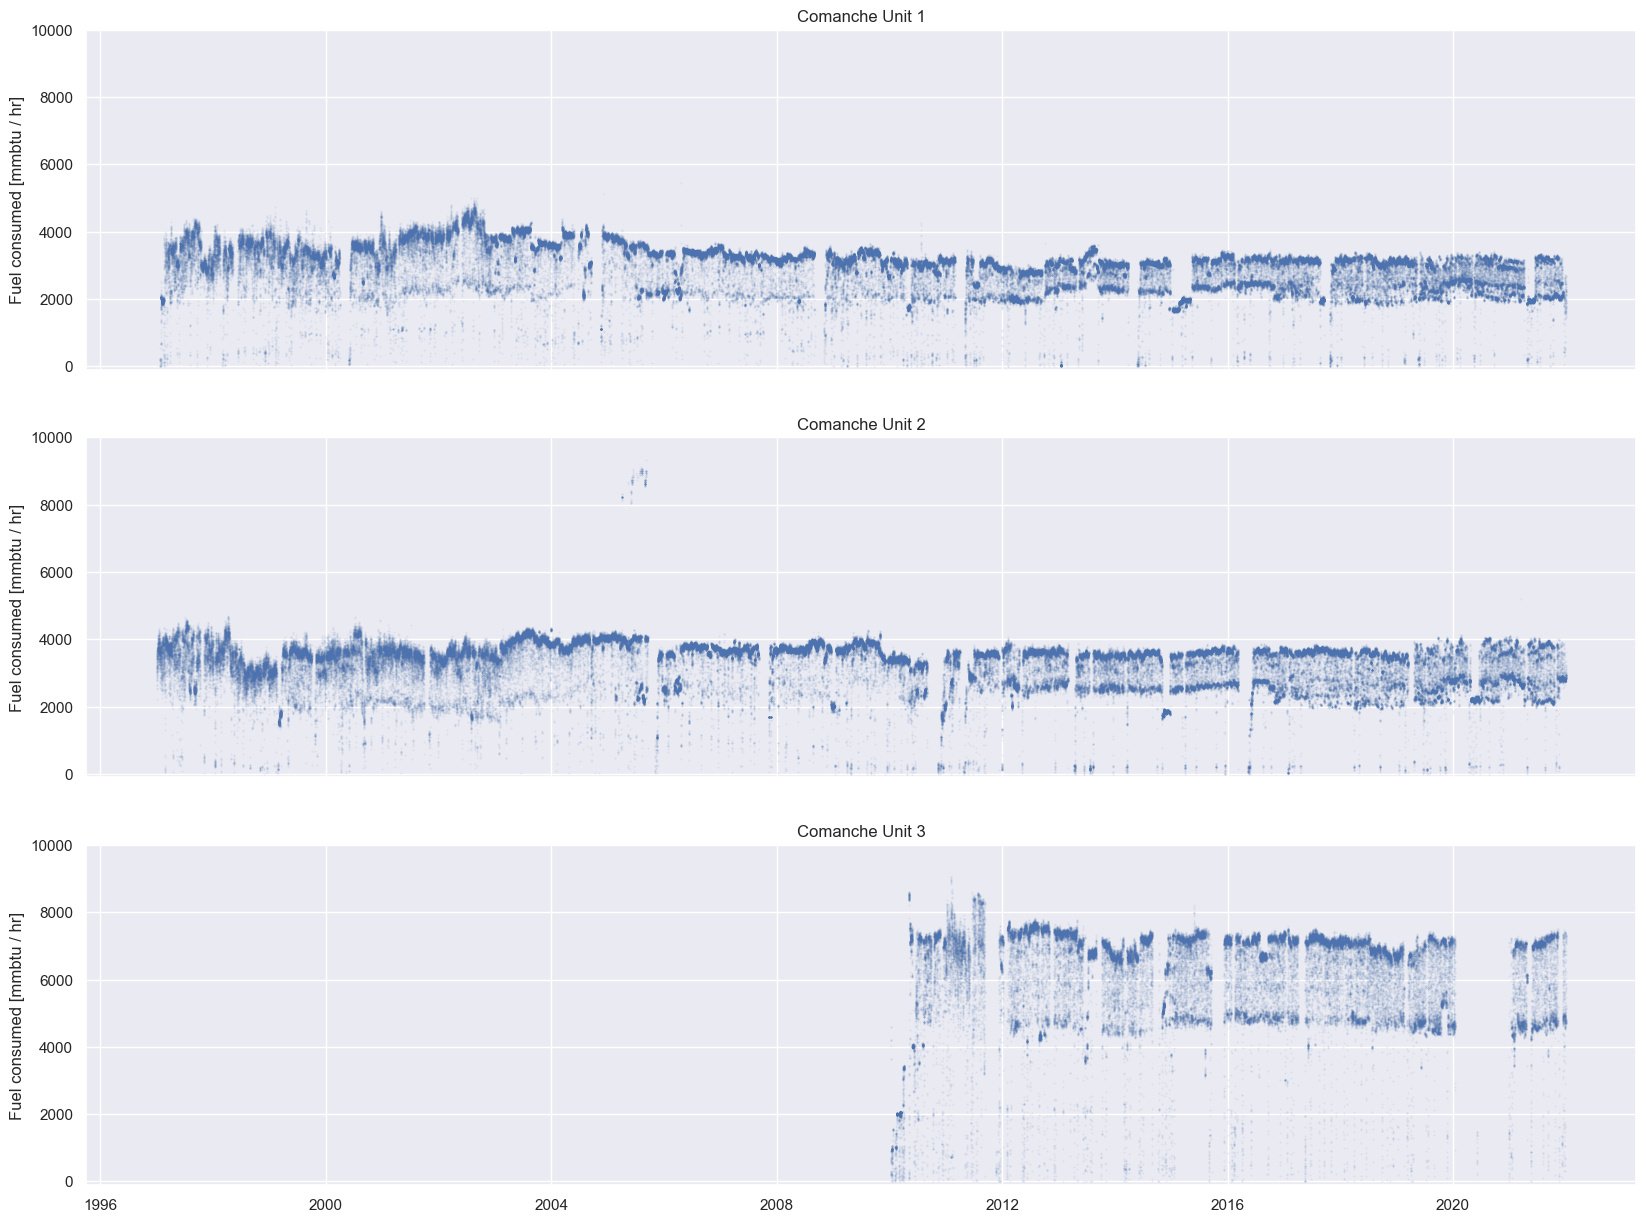

In [17]:
unit_ids = comanche_df.emissions_unit_id_epa.unique()
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, emissions_unit_id_epa in enumerate(comanche_df.emissions_unit_id_epa.unique()):
    axs[n].scatter(
        comanche_df.query("emissions_unit_id_epa==@emissions_unit_id_epa").operating_datetime_utc,
        comanche_df.query("emissions_unit_id_epa==@emissions_unit_id_epa").heat_content_mmbtu,
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(-100,10_000)
    axs[n].set_title(f"Comanche Unit {emissions_unit_id_epa}")
    axs[n].set_ylabel("Fuel consumed [mmbtu / hr]")
plt.show();

### Heat Rate

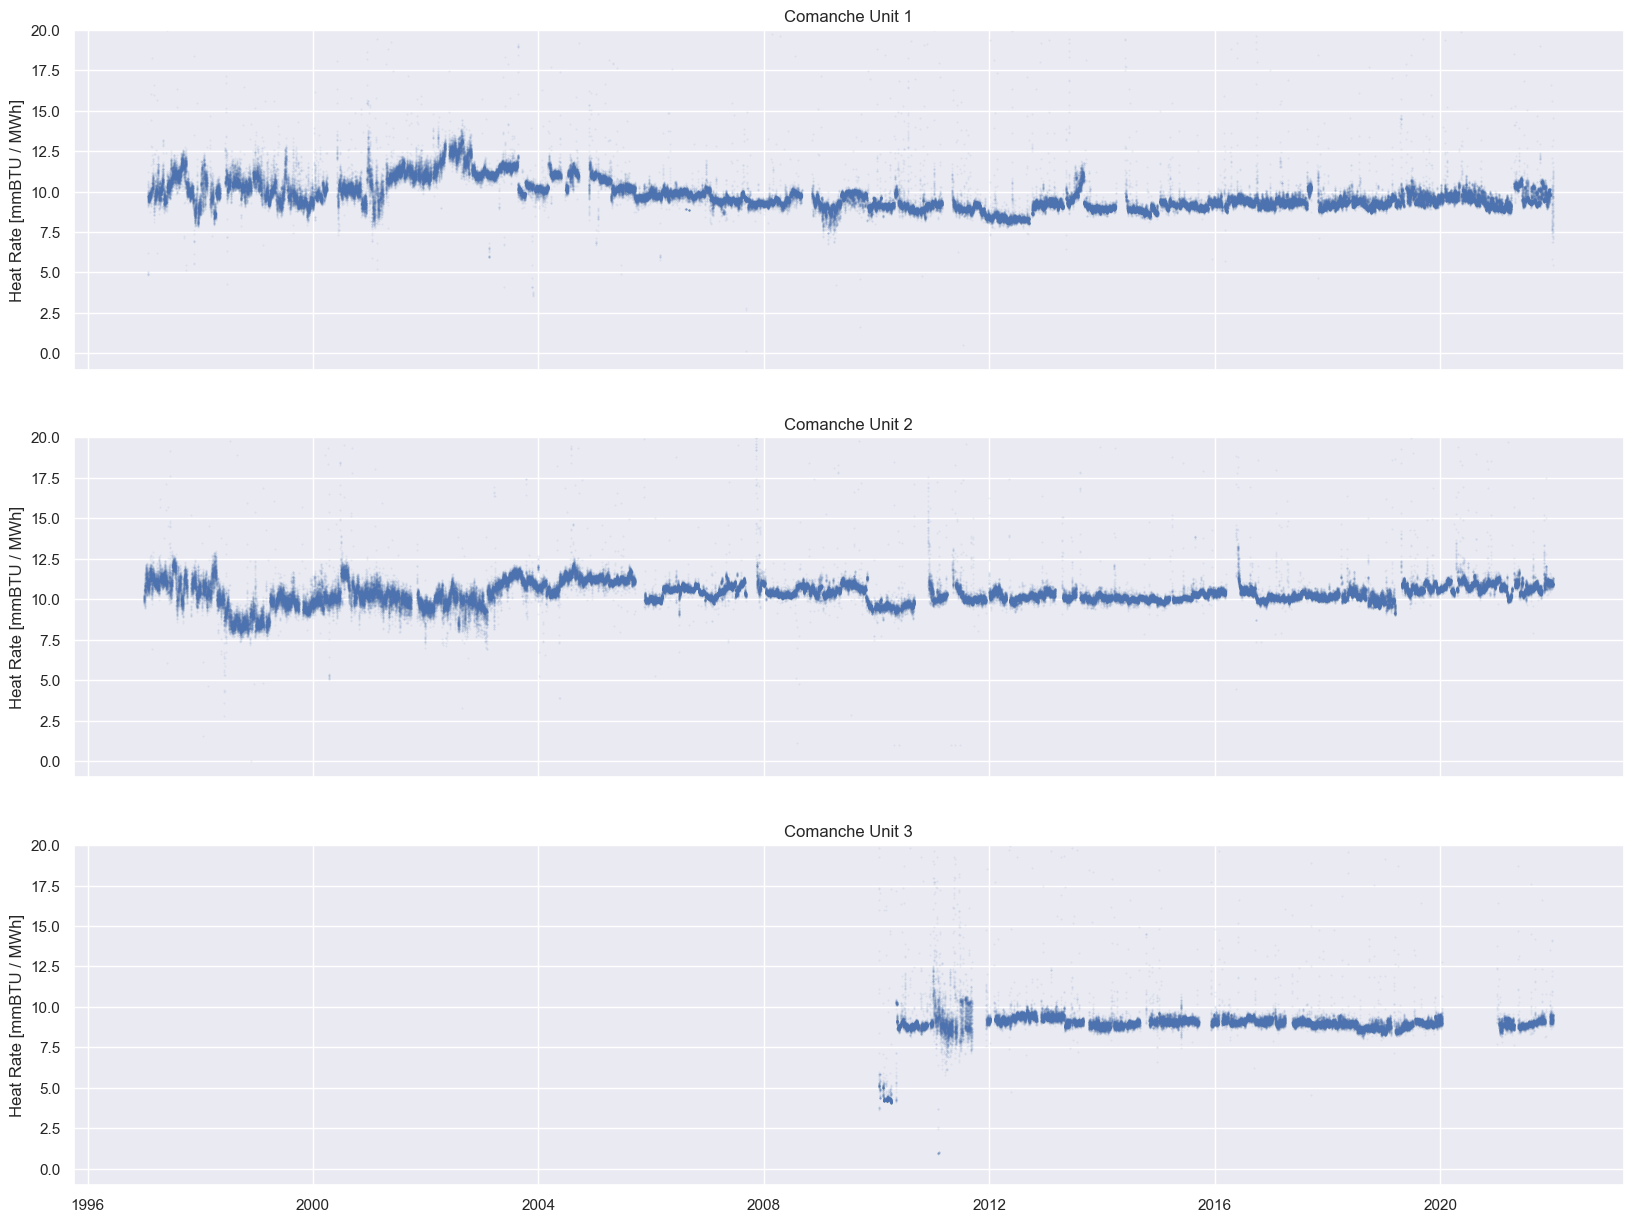

In [18]:
unit_ids = comanche_df.emissions_unit_id_epa.unique()
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, emissions_unit_id_epa in enumerate(comanche_df.emissions_unit_id_epa.unique()):
    axs[n].scatter(
        comanche_df.query("emissions_unit_id_epa==@emissions_unit_id_epa").operating_datetime_utc,
        comanche_df.query("emissions_unit_id_epa==@emissions_unit_id_epa").heat_rate_mmbtu_mwh,
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(-1,20)
    axs[n].set_title(f"Comanche Unit {emissions_unit_id_epa}")
    axs[n].set_ylabel("Heat Rate [mmBTU / MWh]")
plt.show();

### Carbon Intensity

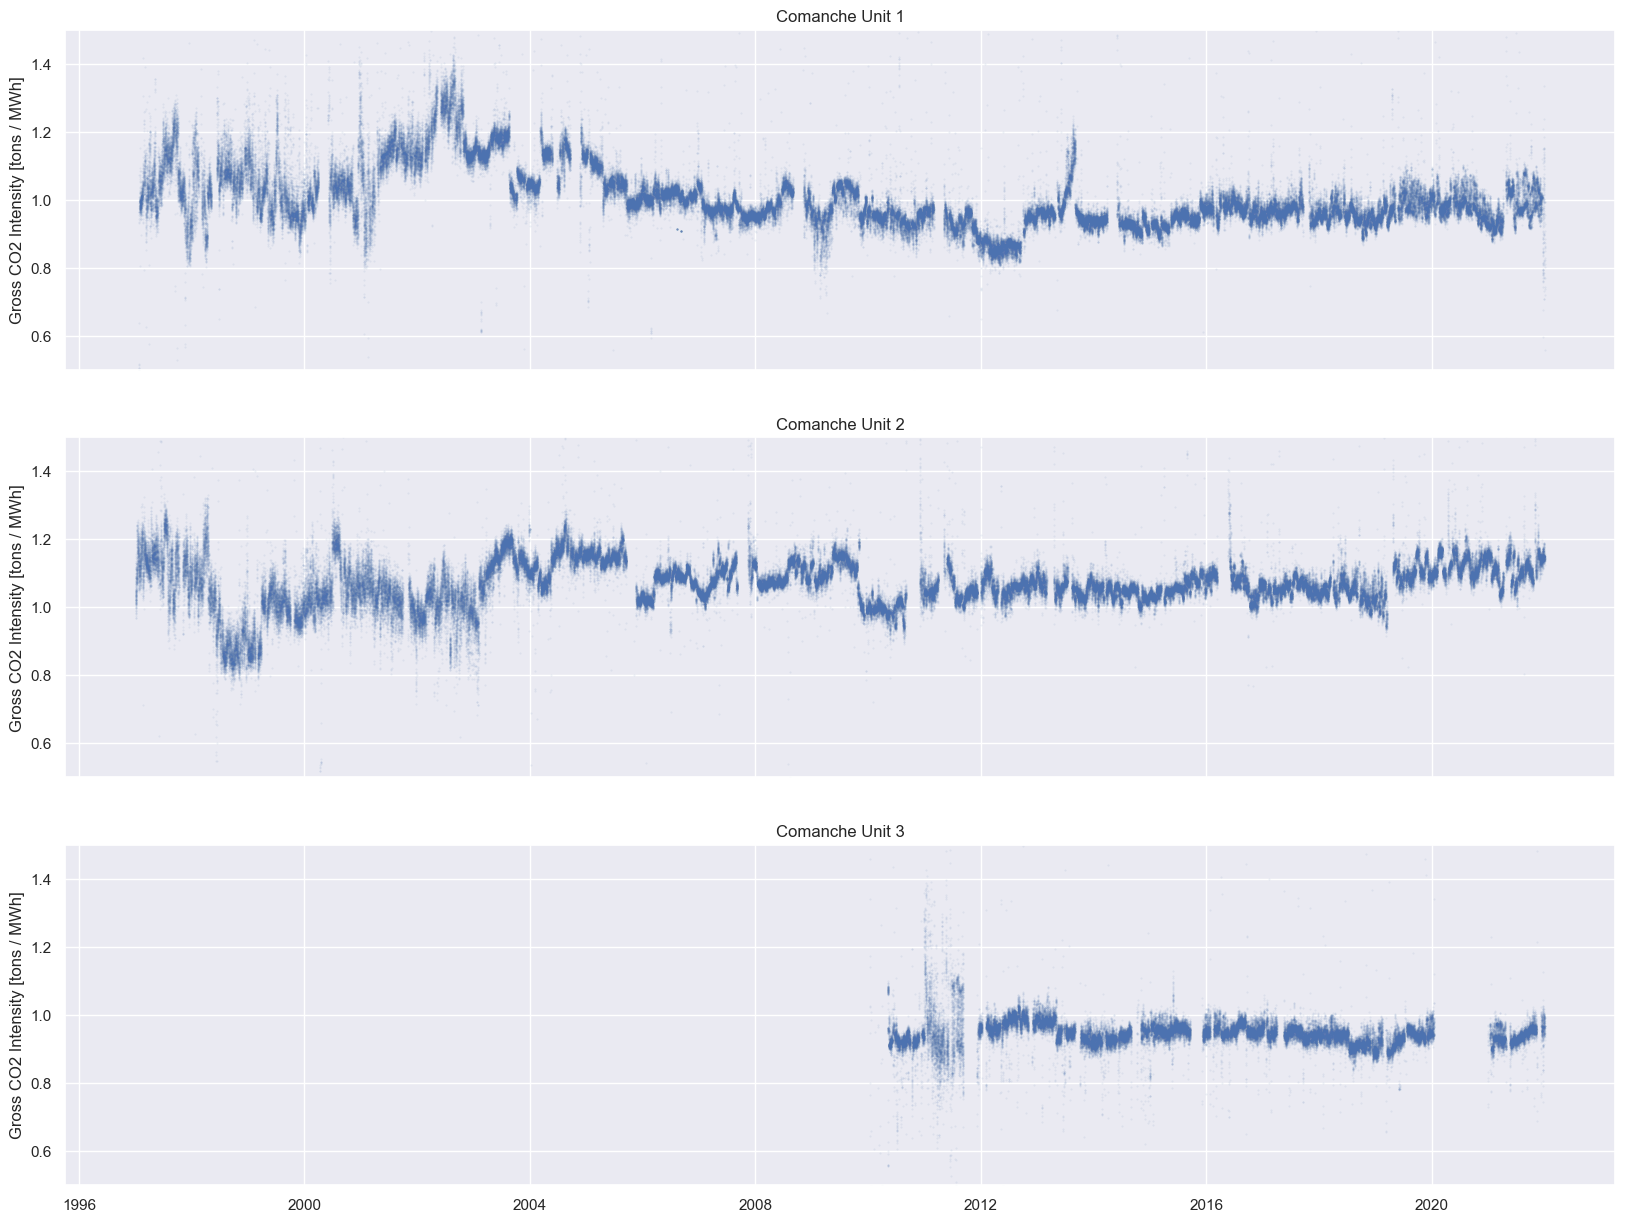

In [19]:
unit_ids = comanche_df.emissions_unit_id_epa.unique()
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, emissions_unit_id_epa in enumerate(comanche_df.emissions_unit_id_epa.unique()):
    axs[n].scatter(
        comanche_df.query("emissions_unit_id_epa==@emissions_unit_id_epa").operating_datetime_utc,
        comanche_df.query("emissions_unit_id_epa==@emissions_unit_id_epa").gross_co2_intensity,
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(0.5,1.5)
    axs[n].set_title(f"Comanche Unit {emissions_unit_id_epa}")
    axs[n].set_ylabel("Gross CO2 Intensity [tons / MWh]")
plt.show();

### Gross Load

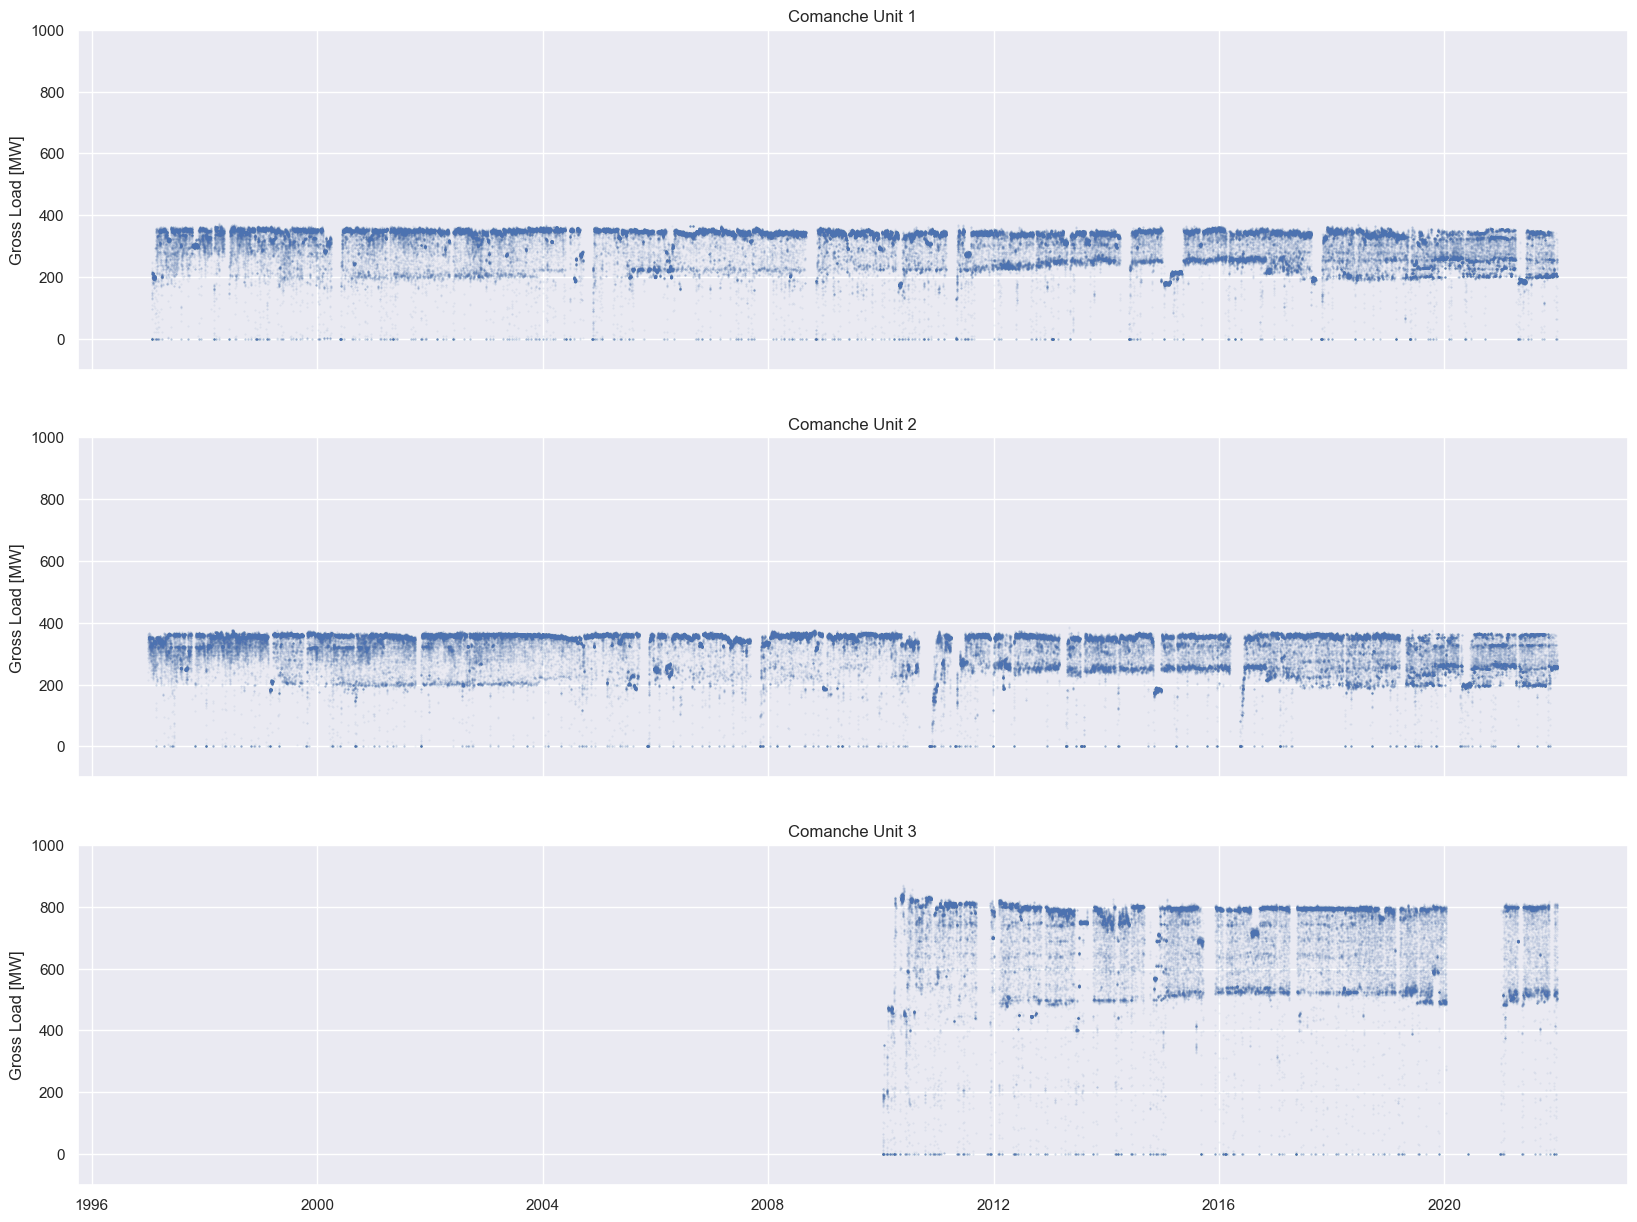

In [20]:
unit_ids = comanche_df.emissions_unit_id_epa.unique()
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, emissions_unit_id_epa in enumerate(comanche_df.emissions_unit_id_epa.unique()):
    axs[n].scatter(
        comanche_df.query("emissions_unit_id_epa==@emissions_unit_id_epa").operating_datetime_utc,
        comanche_df.query("emissions_unit_id_epa==@emissions_unit_id_epa").gross_load_mw,
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(-100,1000)
    axs[n].set_title(f"Comanche Unit {emissions_unit_id_epa}")
    axs[n].set_ylabel("Gross Load [MW]")
plt.show();